## Data loading

Load the "UNSW_NB15_training-set.csv" and "UNSW_NB15_testing-set.csv" into separate PySpark DataFrames.


In [1]:
!pip install -q pyspark kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrwellsdavid/unsw-nb15")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:02<00:00, 56.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mrwellsdavid/unsw-nb15/versions/1


In [3]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("UNSW_NB15_Analysis").getOrCreate()

# Load the training set
df_train = spark.read.csv(path+"/UNSW_NB15_training-set.csv", header=True, inferSchema=True)

# Load the testing set
df_test = spark.read.csv(path+"/UNSW_NB15_testing-set.csv", header=True, inferSchema=True)

In [4]:
df_train.show()

+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

## Data exploration



Explore the training and testing datasets by examining their shapes, data types, descriptive statistics, target variable distribution, and missing values.



In [5]:
from pyspark.sql.functions import count, mean, stddev, min, max, col, when
from pyspark.sql.types import IntegerType, DoubleType, FloatType

# 1. Data Shape
print("Training Data Shape: Rows - {}, Columns - {}".format(df_train.count(), len(df_train.columns)))
print("Testing Data Shape: Rows - {}, Columns - {}".format(df_test.count(), len(df_test.columns)))

# 2. Data Types
print("\nTraining Data Types:")
df_train.printSchema()
print("\nTesting Data Types:")
df_test.printSchema()

# 3. Descriptive Statistics
numerical_cols = [f.name for f in df_train.schema.fields if isinstance(f.dataType, (
    IntegerType, DoubleType, FloatType))]

print("\nTraining Data Descriptive Statistics for Numerical Features:")
df_train.select([mean(c).alias(c) for c in numerical_cols] +
                [stddev(c).alias(c + "_std") for c in numerical_cols] +
                [min(c).alias(c + "_min") for c in numerical_cols] +
                [max(c).alias(c + "_max") for c in numerical_cols]).show()

print("\nTesting Data Descriptive Statistics for Numerical Features:")
df_test.select([mean(c).alias(c) for c in numerical_cols] +
               [stddev(c).alias(c + "_std") for c in numerical_cols] +
               [min(c).alias(c + "_min") for c in numerical_cols] +
               [max(c).alias(c + "_max") for c in numerical_cols]).show()

# 4. Target Variable
print("\nTraining Data Target Variable Distribution:")
df_train.groupBy("label").agg(count("*").alias("count")).show()

print("\nTesting Data Target Variable Distribution:")
df_test.groupBy("label").agg(count("*").alias("count")).show()

# 5. Missing Values
print("\nTraining Data Missing Values:")
df_train.select([count(when(col(c).isNull(), c)).alias(c) for c in df_train.columns]).show()

print("\nTesting Data Missing Values:")
df_test.select([count(when(col(c).isNull(), c)).alias(c) for c in df_test.columns]).show()

Training Data Shape: Rows - 82332, Columns - 45
Testing Data Shape: Rows - 175341, Columns - 45

Training Data Types:
root
 |-- id: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- state: string (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nulla

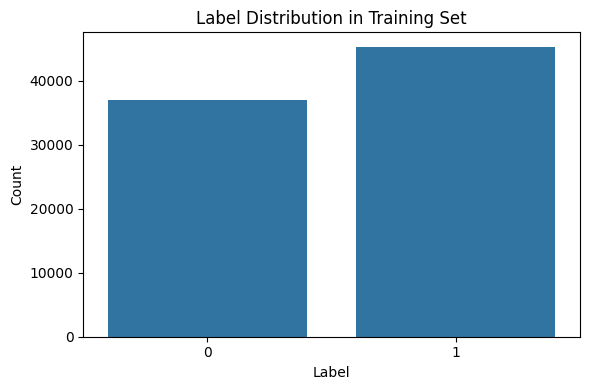

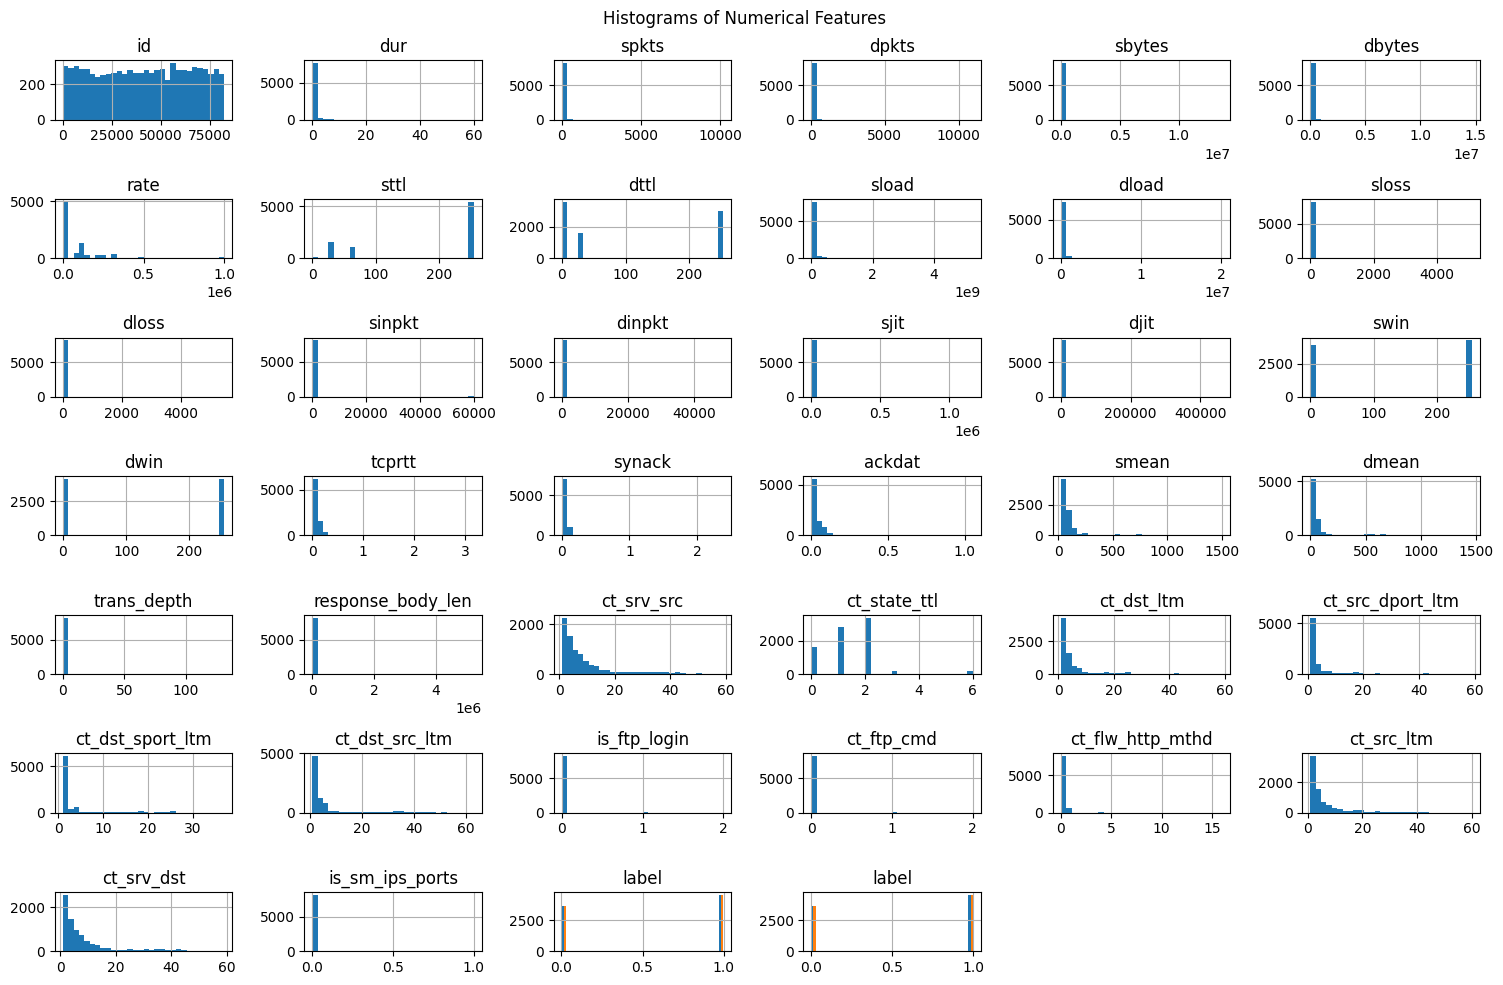

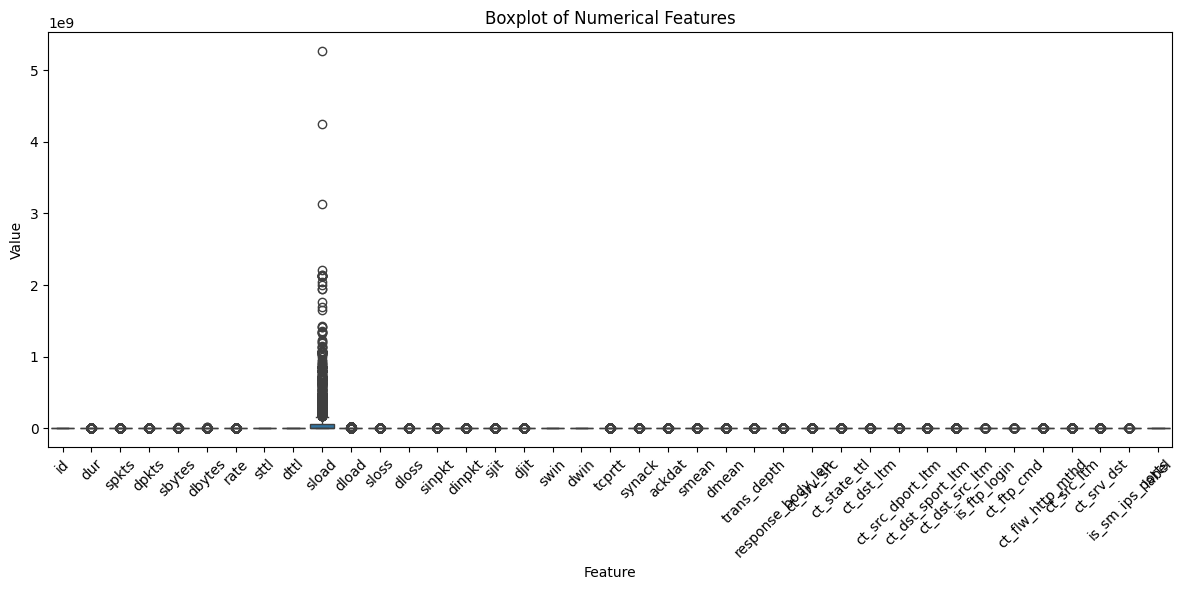

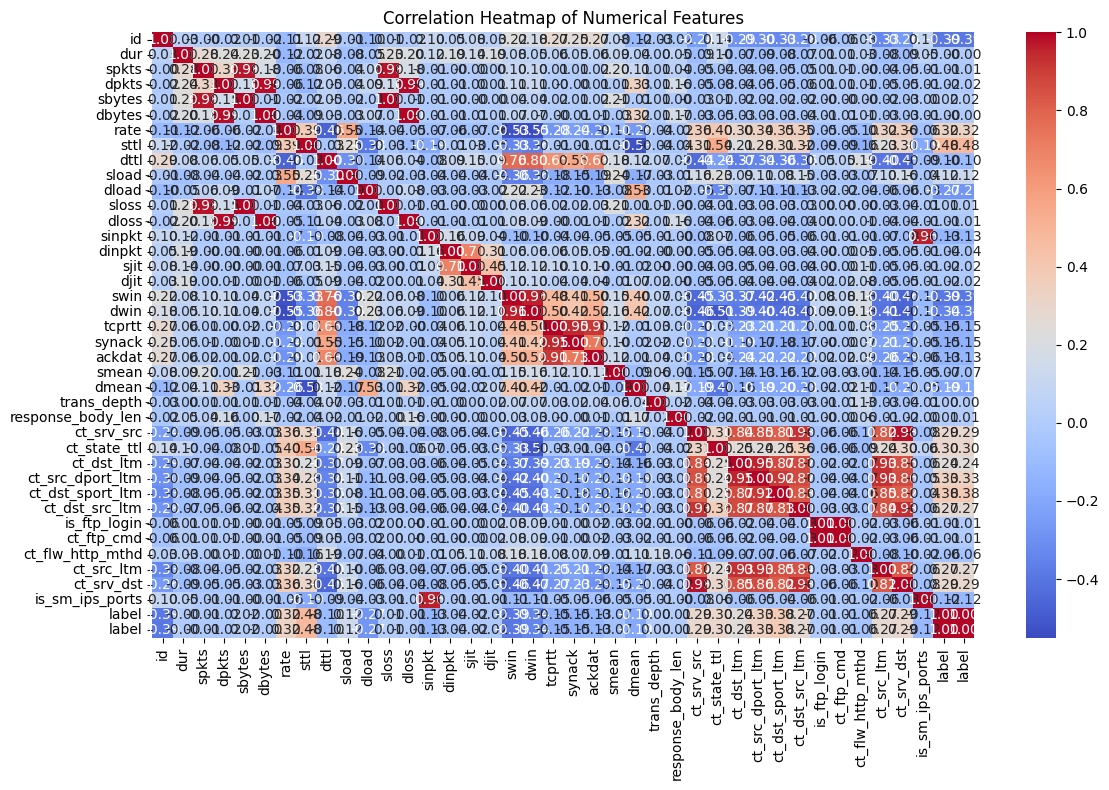

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import count
from pyspark.sql.types import IntegerType, DoubleType, FloatType

# --- Extract numerical columns ---
numerical_cols = [f.name for f in df_train.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType, FloatType))]

# --- Convert to Pandas (sample to avoid memory issues) ---
sampled_train_pd = df_train.select(numerical_cols + ["label"]).sample(False, 0.1, seed=42).toPandas()

# --- Plot 1: Target Variable Distribution ---
label_dist = df_train.groupBy("label").agg(count("*").alias("count")).toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(data=label_dist, x="label", y="count")
plt.title("Label Distribution in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- Plot 2: Histograms for Numerical Features ---
sampled_train_pd[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features")
plt.tight_layout()
plt.show()

# --- Plot 3: Box Plots for Outlier Detection ---
melted = sampled_train_pd[numerical_cols].melt(var_name="Feature", value_name="Value")
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x="Feature", y="Value")
plt.xticks(rotation=45)
plt.title("Boxplot of Numerical Features")
plt.tight_layout()
plt.show()

# --- Plot 4: Correlation Heatmap ---
plt.figure(figsize=(12, 8))
corr_matrix = sampled_train_pd[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

## Data cleaning

Handle any potential missing values in both the training (`df_train`) and testing (`df_test`) DataFrames.


In [7]:
from pyspark.sql.functions import count, when, col

# Check for missing values in the training data
print("Missing values in training data:")
df_train.select([count(when(col(c).isNull(), c)).alias(c) for c in df_train.columns]).show()

# Check for missing values in the testing data
print("Missing values in testing data:")
df_test.select([count(when(col(c).isNull(), c)).alias(c) for c in df_test.columns]).show()

Missing values in training data:
+---+---+-----+-------+-----+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|dur|proto|service|state|spkts|dpkts|sbytes|dbytes|rate|sttl|dttl|sload|dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+---+-----+-------+-----+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+--------------

## Data preparation

Prepare the data for model training by performing data normalization and encoding.


In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# 1. Identify categorical and numerical features
categorical_features = [
    "proto", "service", "state"
]
numerical_features = [
    "dur", "spkts", "dpkts", "sbytes", "dbytes", "rate", "sttl", "dttl", "sload",
    "dload", "sloss", "dloss", "sinpkt", "dinpkt", "sjit", "djit", "swin",
    "stcpb", "dtcpb", "dwin", "tcprtt", "synack", "ackdat", "smean", "dmean",
    "trans_depth", "response_body_len", "ct_srv_src", "ct_state_ttl",
    "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm",
    "is_ftp_login", "ct_ftp_cmd", "ct_flw_http_mthd", "ct_src_ltm", "ct_srv_dst",
    "is_sm_ips_ports"
]

# 2. Create a pipeline for feature transformation
stages = []
for categorical_col in categorical_features:
    stringIndexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + "Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_col + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

pipeline = Pipeline(stages=stages)

# 3. Fit the pipeline on the training data
pipelineModel = pipeline.fit(df_train)

# 4. Transform the training and testing data
df_train_transformed = pipelineModel.transform(df_train)
df_test_transformed = pipelineModel.transform(df_test)

## Data splitting

Split the transformed training data (`df_train_transformed`) into training and validation sets.


In [9]:
from pyspark.ml.tuning import TrainValidationSplit

# Split the data into training and validation sets (80% training, 20% validation)
(df_train_split, df_validation_split) = df_train_transformed.randomSplit([0.8, 0.2], seed=42)

## Feature engineering

Engineer new features from existing ones to potentially improve model performance.


In [10]:
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import DoubleType

# 1. Interaction term: dur_x_rate
df_train_split = df_train_split.withColumn("dur_x_rate", col("dur") * col("rate"))
df_validation_split = df_validation_split.withColumn("dur_x_rate", col("dur") * col("rate"))

# 2. Polynomial feature: sbytes_squared
df_train_split = df_train_split.withColumn("sbytes_squared", col("sbytes") * col("sbytes"))
df_validation_split = df_validation_split.withColumn("sbytes_squared", col("sbytes") * col("sbytes"))

# 3. Categorical feature interaction: proto_state
df_train_split = df_train_split.withColumn("proto_state", col("proto") + "_" + col("state"))
df_validation_split = df_validation_split.withColumn("proto_state", col("proto") + "_" + col("state"))

# 4. UDF example: Calculate the ratio of sbytes to dbytes
def calculate_byte_ratio(sbytes, dbytes):
  if dbytes == 0:
    return 0.0
  return float(sbytes) / dbytes

calculate_byte_ratio_udf = udf(calculate_byte_ratio, DoubleType())

df_train_split = df_train_split.withColumn("byte_ratio", calculate_byte_ratio_udf(col("sbytes"), col("dbytes")))
df_validation_split = df_validation_split.withColumn("byte_ratio", calculate_byte_ratio_udf(col("sbytes"), col("dbytes")))

## Data analysis

Perform correlation analysis and Principal Component Analysis (PCA) on the training data (`df_train_split`) to understand feature relationships and potentially reduce dimensionality.


In [11]:
from pyspark.ml.feature import PCA
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Prepare data for correlation analysis and PCA
numerical_cols = [
    "dur", "spkts", "dpkts", "sbytes", "dbytes", "rate", "sttl", "dttl", "sload",
    "dload", "sloss", "dloss", "sinpkt", "dinpkt", "sjit", "djit", "swin",
    "stcpb", "dtcpb", "dwin", "tcprtt", "synack", "ackdat", "smean", "dmean",
    "trans_depth", "response_body_len", "ct_srv_src", "ct_state_ttl",
    "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm",
    "is_ftp_login", "ct_ftp_cmd", "ct_flw_http_mthd", "ct_src_ltm", "ct_srv_dst",
    "is_sm_ips_ports", "dur_x_rate", "sbytes_squared", "byte_ratio"
]

# Calculate the correlation matrix
vector_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="corr_features")
df_vector = vector_assembler.transform(df_train_split)
matrix = Correlation.corr(df_vector, "corr_features").head()[0]
print("Correlation Matrix:\n", matrix)

# Apply PCA
pca = PCA(k=5, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_train_split)

# Get explained variance ratio for each principal component
explained_variance = model.explainedVariance
print("Explained Variance Ratio for each Principal Component:", explained_variance)

# Transform data with selected principal components
df_pca = model.transform(df_train_split)

Correlation Matrix:
 DenseMatrix([[ 1.00000000e+00,  2.71195981e-01,  2.13357195e-01, ...,
               1.85896444e-02,  7.10777540e-02,  1.20870556e-01],
             [ 2.71195981e-01,  1.00000000e+00,  3.70039721e-01, ...,
               5.93657553e-03,  8.43439813e-02,  3.57009280e-01],
             [ 2.13357195e-01,  3.70039721e-01,  1.00000000e+00, ...,
               5.71859487e-03,  1.05091146e-01,  4.14135274e-02],
             ...,
             [ 1.85896444e-02,  5.93657553e-03,  5.71859487e-03, ...,
               1.00000000e+00, -7.94297385e-04, -7.15897090e-04],
             [ 7.10777540e-02,  8.43439813e-02,  1.05091146e-01, ...,
              -7.94297385e-04,  1.00000000e+00,  2.84972279e-01],
             [ 1.20870556e-01,  3.57009280e-01,  4.14135274e-02, ...,
              -7.15897090e-04,  2.84972279e-01,  1.00000000e+00]])
Explained Variance Ratio for each Principal Component: [0.06908048639447814,0.023611280054788488,0.020510773001212075,0.015869968817195705,0.015

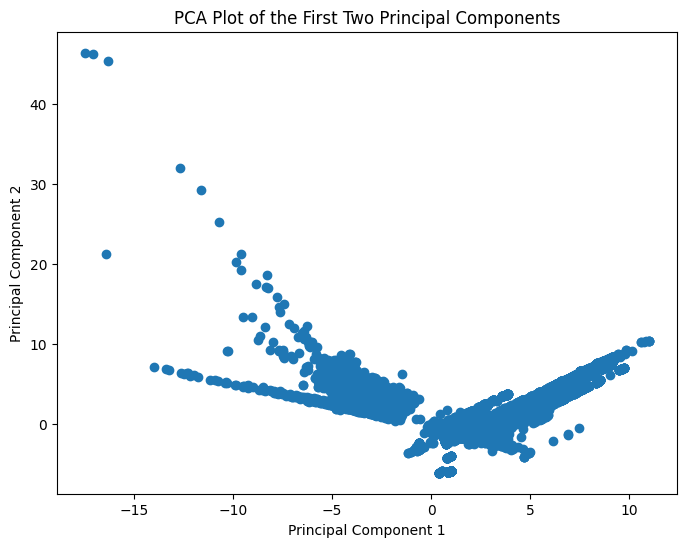

In [12]:
# Convert the first two principal components to a Pandas DataFrame for plotting
pca_df = df_pca.select("pcaFeatures").toPandas()
pca_df['pc1'] = pca_df['pcaFeatures'].apply(lambda x: x[0])
pca_df['pc2'] = pca_df['pcaFeatures'].apply(lambda x: x[1])


plt.figure(figsize=(8, 6))
plt.scatter(pca_df['pc1'], pca_df['pc2'])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot of the First Two Principal Components")
plt.show()

## Model training

Train a K-means model with 20 clusters on the PCA-transformed data stored in `df_pca`.


In [13]:
from pyspark.ml.clustering import KMeans

# Train a K-means model with 20 clusters
kmeans = KMeans(k=20, featuresCol="pcaFeatures")
model = kmeans.fit(df_pca)

# Add cluster labels to the DataFrame
df_kmeans = model.transform(df_pca)

## Model evaluation

Evaluate the performance of the K-means clustering model on `df_kmeans`.


In [14]:
from pyspark.sql.functions import mean

# Calculate the mean of each feature within each cluster
cluster_means = df_kmeans.groupBy("prediction").agg(
    *[mean(c).alias(c + "_mean") for c in numerical_cols]
)

display(cluster_means)

DataFrame[prediction: int, dur_mean: double, spkts_mean: double, dpkts_mean: double, sbytes_mean: double, dbytes_mean: double, rate_mean: double, sttl_mean: double, dttl_mean: double, sload_mean: double, dload_mean: double, sloss_mean: double, dloss_mean: double, sinpkt_mean: double, dinpkt_mean: double, sjit_mean: double, djit_mean: double, swin_mean: double, stcpb_mean: double, dtcpb_mean: double, dwin_mean: double, tcprtt_mean: double, synack_mean: double, ackdat_mean: double, smean_mean: double, dmean_mean: double, trans_depth_mean: double, response_body_len_mean: double, ct_srv_src_mean: double, ct_state_ttl_mean: double, ct_dst_ltm_mean: double, ct_src_dport_ltm_mean: double, ct_dst_sport_ltm_mean: double, ct_dst_src_ltm_mean: double, is_ftp_login_mean: double, ct_ftp_cmd_mean: double, ct_flw_http_mthd_mean: double, ct_src_ltm_mean: double, ct_srv_dst_mean: double, is_sm_ips_ports_mean: double, dur_x_rate_mean: double, sbytes_squared_mean: double, byte_ratio_mean: double]

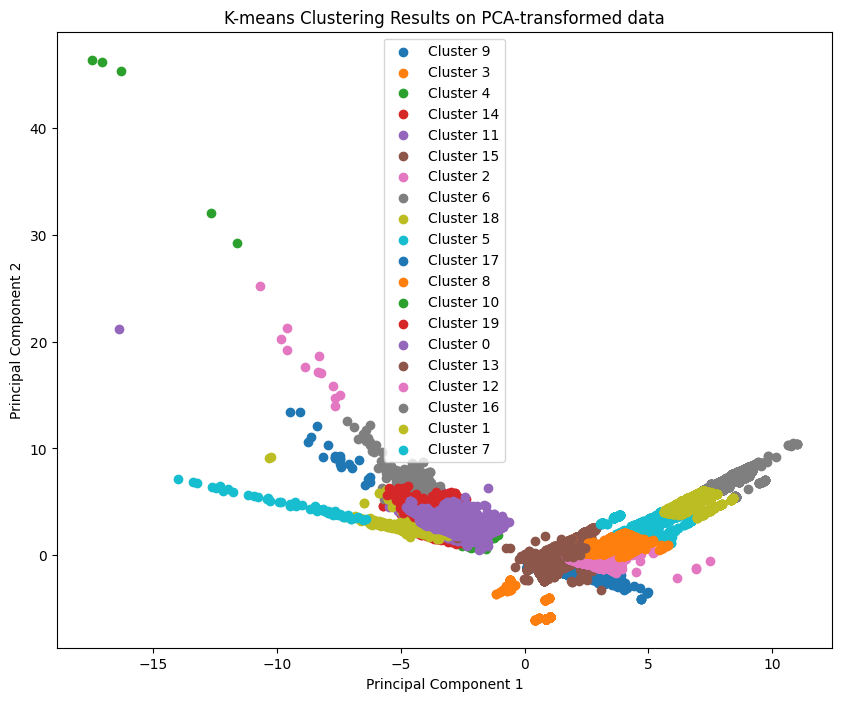

In [15]:
# Select the first two principal components and cluster predictions
pca_kmeans_df = df_kmeans.select("pcaFeatures", "prediction").toPandas()
pca_kmeans_df['pc1'] = pca_kmeans_df['pcaFeatures'].apply(lambda x: x[0])
pca_kmeans_df['pc2'] = pca_kmeans_df['pcaFeatures'].apply(lambda x: x[1])


plt.figure(figsize=(10, 8))
for cluster in pca_kmeans_df['prediction'].unique():
    cluster_data = pca_kmeans_df[pca_kmeans_df['prediction'] == cluster]
    plt.scatter(cluster_data['pc1'], cluster_data['pc2'], label=f"Cluster {cluster}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-means Clustering Results on PCA-transformed data")
plt.legend()
plt.show()


## Model training

Train multiple machine learning models (Decision Trees, Naïve Bayes, Random Forest, Gradient Boosting) using PySpark MLlib on the training data (`df_train_split`)


In [16]:
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, RandomForestClassifier, GBTClassifier

# Create instances of each model
dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label", predictionCol="prediction")
nb = NaiveBayes(featuresCol="scaledFeatures", labelCol="label", predictionCol="prediction")
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", predictionCol="prediction")
gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="label", predictionCol="prediction")

# Train each model
dt_model = dt.fit(df_train_split)
nb_model = nb.fit(df_train_split)
rf_model = rf.fit(df_train_split)
gbt_model = gbt.fit(df_train_split)

## Model evaluation

Evaluate the performance of the trained models (Decision Tree, Naive Bayes, Random Forest, and Gradient Boosting) on the validation set (`df_validation_split`)


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the validation set for each model
dt_predictions = dt_model.transform(df_validation_split)
nb_predictions = nb_model.transform(df_validation_split)
rf_predictions = rf_model.transform(df_validation_split)
gbt_predictions = gbt_model.transform(df_validation_split)

# Evaluate the performance of each model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
nb_accuracy = evaluator.evaluate(nb_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)
gbt_accuracy = evaluator.evaluate(gbt_predictions)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
dt_precision = evaluator.evaluate(dt_predictions)
nb_precision = evaluator.evaluate(nb_predictions)
rf_precision = evaluator.evaluate(rf_predictions)
gbt_precision = evaluator.evaluate(gbt_predictions)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
dt_recall = evaluator.evaluate(dt_predictions)
nb_recall = evaluator.evaluate(nb_predictions)
rf_recall = evaluator.evaluate(rf_predictions)
gbt_recall = evaluator.evaluate(gbt_predictions)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
dt_f1 = evaluator.evaluate(dt_predictions)
nb_f1 = evaluator.evaluate(nb_predictions)
rf_f1 = evaluator.evaluate(rf_predictions)
gbt_f1 = evaluator.evaluate(gbt_predictions)

# Print the evaluation metrics for each model
print("Decision Tree - Accuracy:", dt_accuracy, "Precision:", dt_precision, "Recall:", dt_recall, "F1-score:", dt_f1)
print("Naive Bayes - Accuracy:", nb_accuracy, "Precision:", nb_precision, "Recall:", nb_recall, "F1-score:", nb_f1)
print("Random Forest - Accuracy:", rf_accuracy, "Precision:", rf_precision, "Recall:", rf_recall, "F1-score:", rf_f1)
print("Gradient Boosting - Accuracy:", gbt_accuracy, "Precision:", gbt_precision, "Recall:", gbt_recall, "F1-score:", gbt_f1)

Decision Tree - Accuracy: 0.9323110758140387 Precision: 0.9322808453582191 Recall: 0.9323110758140387 F1-score: 0.9322856964578905
Naive Bayes - Accuracy: 0.7739629788013929 Precision: 0.8047863228945253 Recall: 0.7739629788013929 F1-score: 0.7728177740416751
Random Forest - Accuracy: 0.889730588307166 Precision: 0.8899159283181184 Recall: 0.889730588307166 F1-score: 0.889425337635779
Gradient Boosting - Accuracy: 0.9494165801209603 Precision: 0.9494165801209604 Recall: 0.9494165801209604 F1-score: 0.9494165801209604


## Model optimization

Optimize the Gradient Boosting model using cross-validation and hyperparameter tuning.


In [18]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.01]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .build()

# Define an evaluator for cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Instantiate a CrossValidator object
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit the CrossValidator to the training data
cvModel = cv.fit(df_train_split)

# Store the best model
best_gbt_model = cvModel.bestModel

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

best_gbt_predictions = best_gbt_model.transform(df_validation_split)

# Evaluate the best model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
best_gbt_accuracy = evaluator.evaluate(best_gbt_predictions)

print("Best Gradient Boosting Model - Accuracy:", best_gbt_accuracy)

#Further evaluation metrics for the best model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
best_gbt_precision = evaluator.evaluate(best_gbt_predictions)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
best_gbt_recall = evaluator.evaluate(best_gbt_predictions)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
best_gbt_f1 = evaluator.evaluate(best_gbt_predictions)

print("Best Gradient Boosting Model - Precision:", best_gbt_precision, "Recall:", best_gbt_recall, "F1-score:", best_gbt_f1)


Best Gradient Boosting Model - Accuracy: 0.9771519335328975
Best Gradient Boosting Model - Precision: 0.9771873795818204 Recall: 0.9771519335328975 F1-score: 0.9771596958172375


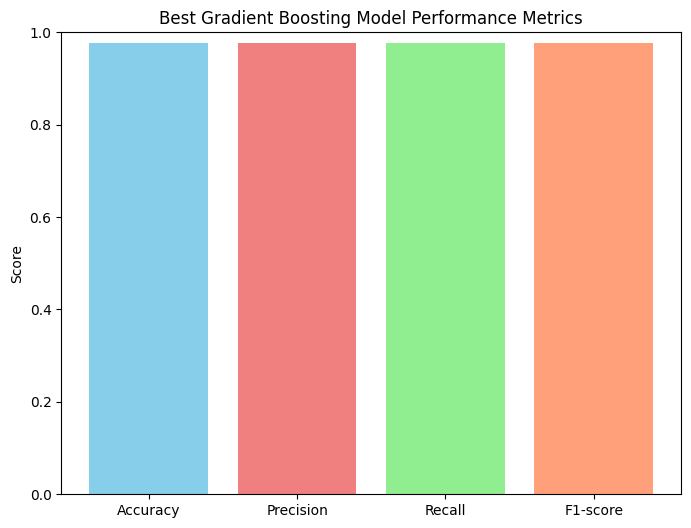

In [20]:
# Create the plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [best_gbt_accuracy, best_gbt_precision, best_gbt_recall, best_gbt_f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'])
plt.title('Best Gradient Boosting Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization
plt.show()


##  DQN-Inspired Neural Network Classifier

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# 1. Convert PySpark DataFrame to Pandas
train_pd = df_train_split.select("scaledFeatures", "label").toPandas()
val_pd = df_validation_split.select("scaledFeatures", "label").toPandas()

# 2. Convert vector column to NumPy arrays
X_train = np.array(train_pd["scaledFeatures"].tolist())
y_train = np.array(train_pd["label"].tolist())

X_val = np.array(val_pd["scaledFeatures"].tolist())
y_val = np.array(val_pd["label"].tolist())

# 3. Define DQN-style Neural Network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input Layer
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))  # Hidden Layer
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))  # Hidden Layer
model.add(Dense(1, activation='sigmoid'))  # Output Layer for binary classification

# 4. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=256, verbose=1)

# 6. Evaluate the model
val_preds = (model.predict(X_val) > 0.5).astype(int)

# 7. Print metrics
print("\nClassification Report:")
print(classification_report(y_val, val_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, val_preds))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7748 - loss: 0.4143 - val_accuracy: 0.9133 - val_loss: 0.1841
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9092 - loss: 0.1943 - val_accuracy: 0.9404 - val_loss: 0.1396
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9335 - loss: 0.1614 - val_accuracy: 0.9436 - val_loss: 0.1314
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9418 - loss: 0.1392 - val_accuracy: 0.9564 - val_loss: 0.1111
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9470 - loss: 0.1276 - val_accuracy: 0.9556 - val_loss: 0.1091
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9493 - loss: 0.1228 - val_accuracy: 0.9571 - val_loss: 0.1061
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9537 - loss: 0.1151 - val_accuracy: 0.9588 - val_loss: 0.1015
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9534 - loss: 0.1154 - val_accuracy: 0.

## Plot Training History

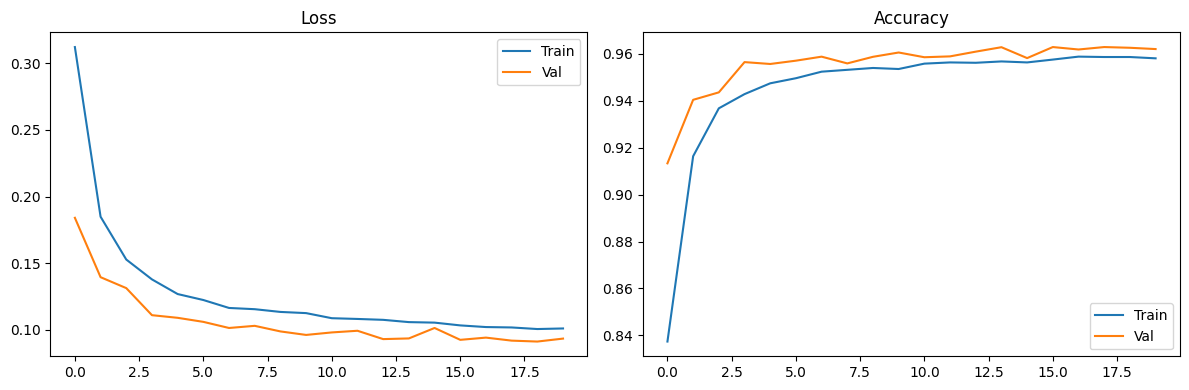

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()